In [1]:
import numpy as np
import re
import pandas as pd
from tqdm.notebook import tqdm
from datasets import load_dataset
import umap
import altair as alt
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from typing import List
import enum

from langchain_community.llms import Ollama
from langchain.output_parsers.regex_dict import RegexDictParser
from langchain.output_parsers import PydanticOutputParser
from langchain_core.messages import HumanMessage, SystemMessage, ChatMessage
from langchain.prompts import ChatPromptTemplate, PromptTemplate
from pydantic import BaseModel, Field, validator, create_model
from openai import AsyncOpenAI, OpenAI
import asyncio
import os

import requests
import json

import itertools
from copy import deepcopy
from tqdm.notebook import tqdm, trange
from sklearn.cluster import KMeans

import umap.umap_ as umap
#import umap
import hdbscan

from typing import Literal, Union
from pydantic.config import ConfigDict

from src.context import context

from src.utilities import *
from src.bubble import *

import instructor
from llama_cpp import Llama



Retrieved company www.amazon.com : 1707858349473x785784134804136600
Retrieved project Amazon_trustpilot : 1707841778067x515781546632932540


In [2]:
csv_path = 'data/Trustpilot/www.darty.com.xlsx'
#csv_path = 'data/Trustpilot/www.amazon.com.xlsx'
feedbacks_df = pd.read_excel(csv_path, )
feedbacks_df['Date'] = pd.to_datetime(feedbacks_df['Date'], format='%B %d, %Y', errors='coerce')
feedbacks_df['Content'] = feedbacks_df['Content'].fillna('')

feedbacks_df['Year'] = pd.DatetimeIndex(feedbacks_df['Date']).year
feedbacks_df['Month'] = pd.DatetimeIndex(feedbacks_df['Date']).month

feedbacks_df.head()

,Title,Date,Content,Page,Username,Total reviews,Location,Rating,Year,Month
0,Amazon have stopped posting reviews of…,2024-02-12,Amazon have stopped posting reviews of Ring do...,1,SISYPHUS 48,27 reviews,GB,1,2024,2
1,￼ Professionalism through customer service Ama...,2024-02-13,There was a mix up with the payment arrangemen...,1,Charles A Pleasant,2 reviews,US,5,2024,2
2,I purchased a solar panel,2024-02-08,I purchased a solar panel. When the item arriv...,1,Rodger Smith,7 reviews,GB,1,2024,2
3,Such a rubbish company didn't see in my…,2024-01-01,Such a rubbish company didn't see in my lifeI ...,1,smart boy,1 review,AF,1,2024,1
4,Ease of Doing Biz: It’s a line of BS!,2024-02-13,Amazon allows you to review everyone except th...,1,Utterly Disappointed,1 review,US,2,2024,2


In [3]:
grouped_data = feedbacks_df.groupby(feedbacks_df['Date'].dt.year)
mean_rating = feedbacks_df.groupby(feedbacks_df['Date'].dt.year).Rating.mean()
group_count = grouped_data.Title.count()

x = np.array(mean_rating.index)
y = group_count
c = mean_rating

In [5]:
import plotly.express as px

# Assuming your arrays are named x, y, and c
fig = px.scatter(x=x, y=y, color=c)
fig.show()

In [6]:
from scipy.interpolate import interp1d

x_new = np.linspace(x.min(), x.max(),5000)

y_smooth = interp1d(x, y, kind='quadratic')(x_new)
c_smooth = interp1d(x, c, kind='quadratic')(x_new)
size = [0.1 for _ in x_new]

fig = px.scatter(x=x_new, y=y_smooth, color=c_smooth)
fig.show()



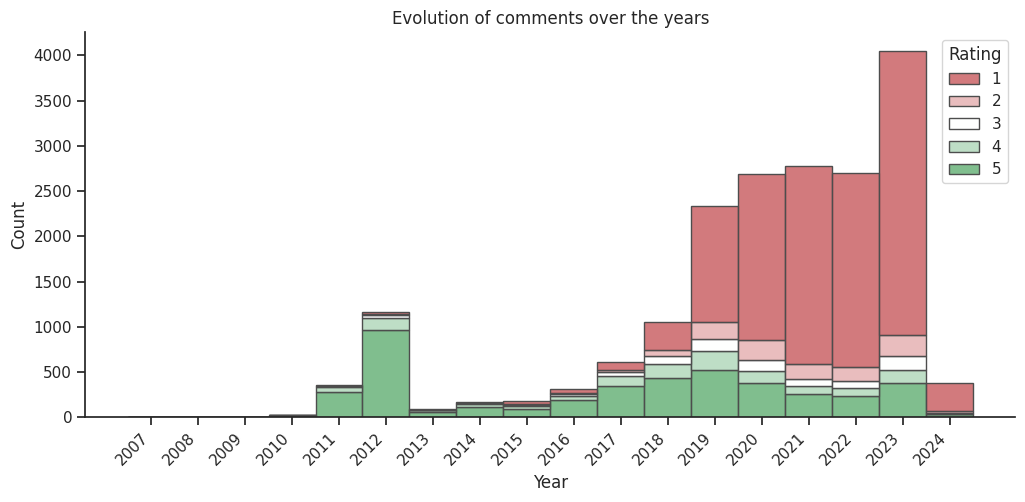

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

sns.set_theme(style="ticks")

f, ax = plt.subplots(figsize=(12, 5))
sns.despine(f)

cmap = LinearSegmentedColormap.from_list("rg", ["r", "w", "g"], N=256)

# Assuming 'Year' is a numeric column representing years
if not pd.api.types.is_numeric_dtype(feedbacks_df['Year']):
    feedbacks_df['Year'] = pd.to_numeric(feedbacks_df['Year'], errors='coerce')  # Handle non-numeric data

# Ensure unique years and sort
unique_years = feedbacks_df['Year'].unique()
unique_years.sort()

# Set x-axis ticks
ax.set_xticks(unique_years)

# Remove space between bars (if applicable)
sns.histplot(
    feedbacks_df,
    x="Year",
    hue="Rating",
    multiple="stack",
    palette=cmap,
    edgecolor=".3",
    discrete=True,
      # Set rwidth=1 to remove spacing (might need adjustments based on plot)
)

# Rotate and align x-axis labels (optional)
ax.set_xticklabels(labels=unique_years, rotation=45, ha='right')

plt.title("Evolution of comments over the years")
plt.show()


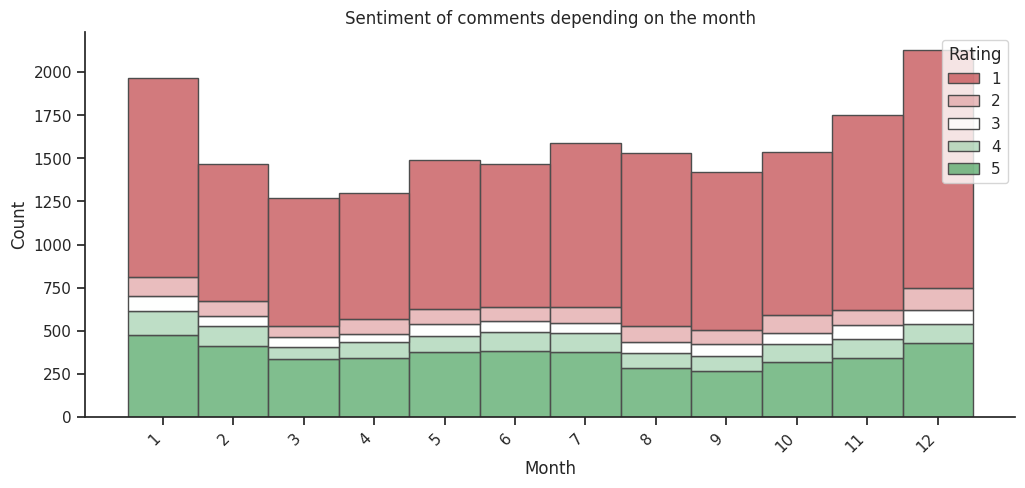

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

sns.set_theme(style="ticks")

f, ax = plt.subplots(figsize=(12, 5))
sns.despine(f)

cmap = LinearSegmentedColormap.from_list("rg", ["r", "w", "g"], N=256)

# Assuming 'Year' is a numeric column representing years
if not pd.api.types.is_numeric_dtype(feedbacks_df['Month']):
    feedbacks_df['Month'] = pd.to_numeric(feedbacks_df['Month'], errors='coerce')  # Handle non-numeric data

# Ensure unique years and sort
unique_years = feedbacks_df['Month'].unique()
unique_years.sort()

# Set x-axis ticks
ax.set_xticks(unique_years)

# Remove space between bars (if applicable)
sns.histplot(
    feedbacks_df,
    x="Month",
    hue="Rating",
    multiple="stack",
    palette=cmap,
    edgecolor=".3",
    discrete=True,
      # Set rwidth=1 to remove spacing (might need adjustments based on plot)
)

# Rotate and align x-axis labels (optional)
plt.title("Sentiment of comments depending on the month")
ax.set_xticklabels(labels=unique_years, rotation=45, ha='right')

plt.show()

In [9]:

df = feedbacks_df.copy()
df['Date'] = df['Date'].astype(str)

batchs = batchify(df, 1000)
for batch in tqdm(batchs):
    bubble_client.create(
        "Feedback",
        [{
            "Company": COMPANY_ID,
            "Content": row["Title"]+'\n'+row["Content"],
            "Date": row["Date"],
            "Location": row['Location'],
            "Sentiment": row['Rating'],
            "Project": PROJECT_ID,
            "Source": "Trustpilot",
        } for _,row in batch.iterrows()] )

0it [00:00, ?it/s]